# INF-395/477 Redes Neuronales Artificiales I-2018
## Tarea 3 -  Redes Recurrentes y Autoencoders
> Juan Pablo Cruz 201473004-7

> Felipe Chacón 201303017-3

El siguiente trabajo se compone de 2 partes, en la primera se trabajará con Redes Neuronales Recurrentes utilizando principalmente el dataset *Annotated Named Entry*, y en la segunda parte se trabajará con AutoEncoders, utilizando el dataset *MNIST*.

---


1. RNN sobre texto
2. Autoencoders (AEs) en MNIST
> 2.1 Reducción de dimensionalidad

>> 2.2 Denoising

>> 2.3 Similarity reconstruct

>> 2.4 Pre-training

## 1. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (Groningen Meaning Bank), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de Kaggle, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo many to many y many to one.

**Descripción del dataset**

El dataset sobre el que se trabajará es *Annotated Named Entity Dataset*, que contiene un gran número de sentencias separas por palabras, en donde por cada palabra se cuenta con diversa información de esta, como por ejemplo, la palabra siguiente y previa de la sentencia, el *lemma* de esta palabra, su categoría o el tipo de entidad que es, etc. Este dataset, y por lo tanto sus caracteristicas, estan pensadas para realizar la tarea de *Named Entity Recognition*.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.layers import CuDNNGRU, GRU
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Se lee la data, la cual esta almacenada en googledrive
df_ner = pd.read_csv("/content/gdrive/My Drive/t3_ann_data/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [0]:
df_ner

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,...,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,...,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,...,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,...,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,...,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


a) En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**

Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los las etiquetas (*tags*), esto es un arreglo de arreglos de *lemmas* y un arreglo de arreglos de *tags* respectivamente. **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**


Se utilizará el lemma de las palabras en lugar de la palabra completa, ya que de esta forma se reduce el número de palabras con el que se trabajará debido a que diferentes palabras contienen el mismo lemma, lo que además no afecta en esta tarea de clasificación, ya que todas las palabras con el mismo lemma debiesen ser de la misma clase.

A continuación se ordena el conjunto de datos a utilizar, dejando las sentencias de lemmas y sus respectivas labels. Además se crean los conjuntos de lemmas y labels.

In [0]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

dataX,dataY = [],[]
lemmas,labels = set(), set()  #uniques
sentence, labels_sentence = [], []
for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[3]) #TAG
dataX = np.asarray(dataX[1:]) #data to  array
dataY = np.asarray(dataY[1:])

In [0]:
print(dataX[0])
print(dataX[1])
print(dataX[0].shape)
print(dataX[1].shape)
print("Dimensiones dataX: ",dataX.shape)
print("Dimensiones dataY: ",dataY.shape)

['thousand' 'of' 'demonstr' 'have' 'march' 'through' 'london' 'to'
 'protest' 'the' 'war' 'in' 'iraq' 'and' 'demand' 'the' 'withdraw' 'of'
 'british' 'troop' 'from' 'that' 'countri' '.']
['famili' 'of' 'soldier' 'kill' 'in' 'the' 'conflict' 'join' 'the'
 'protest' 'who' 'carri' 'banner' 'with' 'such' 'slogan' 'as' '"' 'bush'
 'number' 'one' 'terrorist' '"' 'and' '"' 'stop' 'the' 'bomb' '.' '"']
(24,)
(30,)
Dimensiones dataX:  (48081,)
Dimensiones dataY:  (48081,)


Ambas estructuras tienen las mismas dimensiones. Es importante notar que no todas las sentencias(datos) tienen el mismo largo(dimensiones), por ejemplo la sentencia 0 tiene un largo de 24, mientras que la sentencia 1 tiene un largo de 30.

b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

Por lo anterior se estudiará la distribución de los largos de las sentencias a procesar. También se estudiará el comportamiento de la cantidad de veces que se repite cada palabra dentro de todos los textos a utilizar.

In [0]:
#Se calculan los largos de cada dato ademas de crear un diccionario con cada lemma y su cantidad de repeticiones
largos = []
palabras = set()
palabras_dic = dict()
for frase in dataX:
    largos.append(frase.shape[0])
    for palabra in frase:
        if palabra not in palabras:
            palabras.add(palabra)
            palabras_dic[palabra] = 1
        else:
            palabras_dic[palabra] += 1
vecesPalabras_ordenadas = sorted(palabras_dic.values())[::-1]

Text(0,0.5,'Cantidad de sentencias')

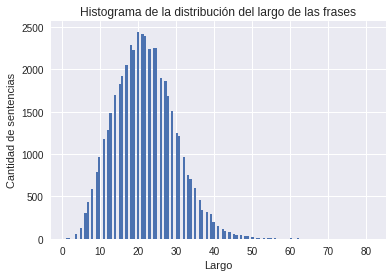

In [0]:
plt.hist(largos, bins='auto')
plt.title("Histograma de la distribución del largo de las frases")
plt.xlabel('Largo')
plt.ylabel('Cantidad de sentencias')

In [0]:
print("Promedio de los largos: %s" %(np.mean(largos)))
print("Mediana de los largos: %s" %(np.median(largos)))

Promedio de los largos: 21.854495538778313
Mediana de los largos: 21.0


Observando el histograma y el promedio y la mediana, se puede concluir aproximadamente que los largos de las sentencias de la data que se tiene, siguen una distribución normal con un leve sesgo positivo, además de tener un promedio de 21.85.

A continuación se verá la cantidad de repeticiones por palabra.

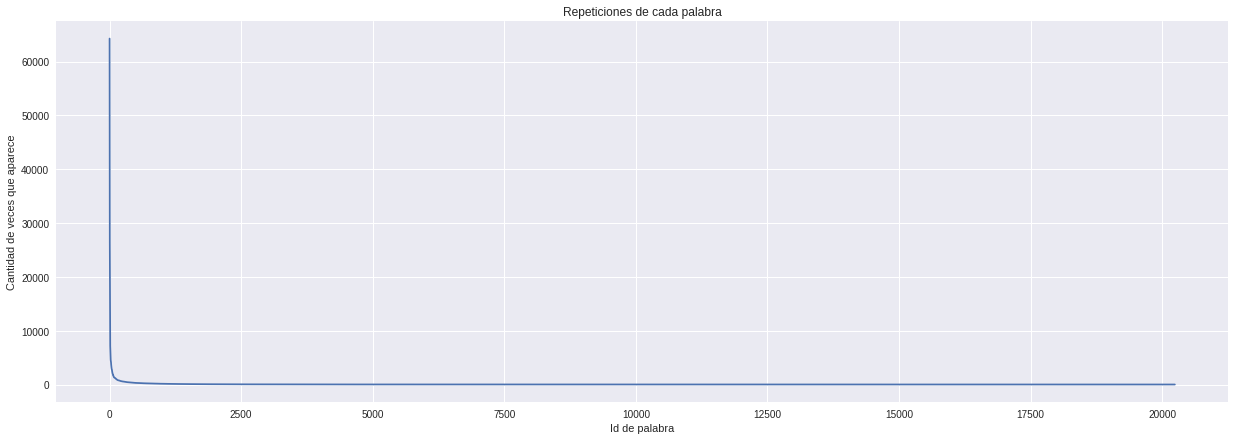

In [0]:
plt.figure(figsize=(21,7))
plt.title("Repeticiones de cada palabra")
plt.xlabel('Id de palabra')
plt.ylabel('Cantidad de veces que aparece')
plt.plot(vecesPalabras_ordenadas)

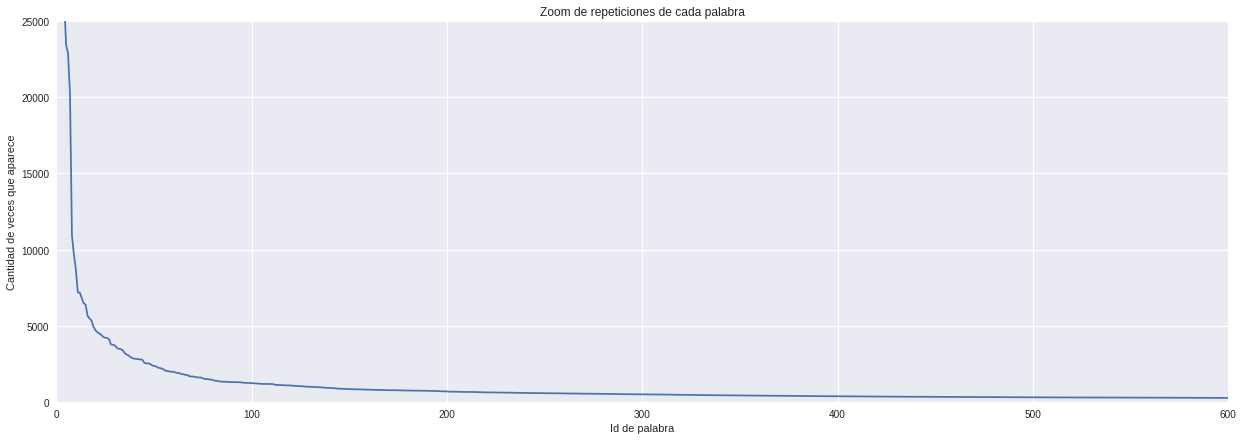

In [0]:
plt.figure(figsize=(21,7))
plt.ylim(top=25000)
plt.xlim(right=600)
plt.title("Zoom de repeticiones de cada palabra")
plt.xlabel('Id de palabra')
plt.ylabel('Cantidad de veces que aparece')
plt.plot(vecesPalabras_ordenadas)

Viendo este gráfico (el que es un zoom hacia el origen del gráfico anterior) se puede apreciar que existe una **ley Zipf**, lo que significa que la curva sigue una forma: $$\frac{1}{n^\alpha}$$

En este caso se observa una curva muy pronunciada, decayendo practicamente por completo ya en la palabra número 100.

Ya que se quiere hacer una tarea de clasificación, es importante saber como estan distribuidas las cantidades de datos de cada clase con los que se cuenta. Por esto a continuación se verá si estas cantidades estan balanceadas o no.

In [0]:
clases = set()
clases_dic = dict()
for frase in dataY:
    for clase in frase:
        if clase not in clases:
            clases.add(clase)
            clases_dic[clase] = 1
        else:
            clases_dic[clase] += 1


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

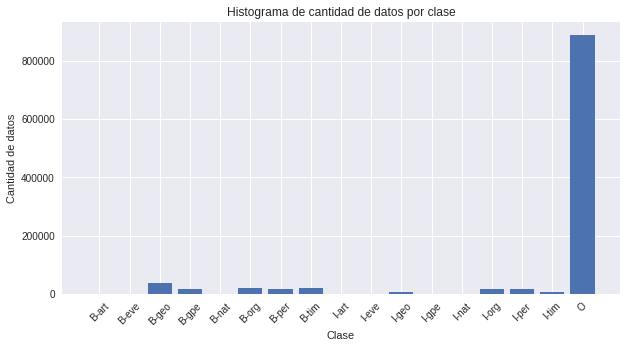

In [0]:
plt.figure(figsize=(10,5))
plt.bar(clases_dic.keys(),clases_dic.values())
plt.title("Histograma de cantidad de datos por clase")
plt.xlabel('Clase')
plt.ylabel('Cantidad de datos')
plt.xticks(rotation=45)

Con este histograma se observa claramente que existe un desbalance en las clases de los datos que se tienen. Esto significa que se deberá utilizar una métrica más acorde a esto para evaluar los modelos.

c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo que será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. **Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas**. Además de esto, debido al largo distinto de las sentencias se deberá **realizar *padding* para estandarizar el largo**, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*0, 0*].

Para utilizar los textos en las redes neuronales, se tienen que pasar a números, por esto se crearán diccionarios para los *lemmas* y las etiquetas, relacionando cada una a un número. También se creará un diccionario inverso, permitiendo obtener la palabra contando solamente con el número. Los números empiezan desde 1, para dejar el valor 0 libre, ya que este será utilizado para representar un carácter de relleno. Finalmente se aplica esta transformación al conjunto de datos y al de etiquetas.

In [0]:
lemma2idx = {w: (i+1) for i, w in enumerate(lemmas)}
idx2lemma = {(i+1): w for i, w in enumerate(lemmas)}
lab2idx = {t: (i+1) for i, t in enumerate(labels)}
idx2lab = {(i+1): t for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
lemma2idx["yourspecialcharacter"] = 0
idx2lemma[0] = "yourspecialcharacter"
lab2idx["endtagger"] = 0
idx2lab[0] = "endtagger"
n_lemmas = len(lemmas)+1
n_labels = len(labels)+1

In [0]:
lab2idx

{'B-art': 12,
 'B-eve': 3,
 'B-geo': 16,
 'B-gpe': 15,
 'B-nat': 11,
 'B-org': 5,
 'B-per': 14,
 'B-tim': 1,
 'I-art': 7,
 'I-eve': 6,
 'I-geo': 4,
 'I-gpe': 13,
 'I-nat': 8,
 'I-org': 10,
 'I-per': 2,
 'I-tim': 17,
 'O': 9,
 'endtagger': 0}

d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece más conveniente al rellenar con un valor especial respecto al cómo funciona una red recurrente y cómo funciona su memoria **¿Al principio o al final de la sentencia?** Comente

Debido a como se vió al principio, no todas las sentencias tienen el mismo largo, por lo que para mitigar esto se utilizará padding, rellenando con el carácter anteriormente creado en el número 0. Con esto se dejarán todos los datos del mismo largo, pero primero se debe ver cual es el largo máximo.

In [0]:
max_lenght = 0
for sentencia in dataX:
    if len(sentencia)>max_lenght:
        max_lenght = len(sentencia)

El padding en este caso se hace al principio de la sentencia.

In [0]:
X = sequence.pad_sequences(dataX,maxlen=max_lenght,padding='pre',value=lemma2idx["yourspecialcharacter"]) 
y = sequence.pad_sequences(dataY,maxlen=max_lenght,padding='pre',value=lab2idx["endtagger"])

In [0]:
X

array([[    0,     0,     0, ..., 18542,  8361, 18363],
       [    0,     0,     0, ...,  2899, 18363, 16620],
       [    0,     0,     0, ...,  1792, 19041, 18363],
       ...,
       [    0,     0,     0, ...,  6934,  1370, 18363],
       [    0,     0,     0, ...,  9256,  9603, 18363],
       [    0,     0,     0, ..., 16226, 18657, 18363]], dtype=int32)

e) Para el poder entregar una clasificación sobre los distintos *tags* es necesario tranformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [0]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [0]:
X_train.shape

(33656, 81)

In [0]:
y_train.shape

(33656, 81, 18)

In [0]:
X_test.shape

(14425, 81)

In [0]:
y_test.shape

(14425, 81, 18)

En el caso de la entrada del conjunto de entrenamiento, la dimensión es de 81, los que pertenencen a cada una de los *lemmas* de cada sentencia y la dimensión de salida es de 81x18, o sea, retorna un vector de largo 18 por cada uno de los *lemmas* relacionados a los datos de entrada. El conjunto de test tiene las mismas dimensiones, la diferencia entre ambos conjuntos es la cantidad de datos (sentencias) que contiene en donde el primero tiene un total de 33656, mientras que el de test contiene 14425.

f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases como identificó en el punto b).


In [0]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_5 (Dense)              (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.5067 - val_loss: 0.2187
Epoch 2/3
33656/33656 [==============================] - 65s 2ms/step - loss: 0.1753 - val_loss: 0.1156
Epoch 3/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.0870 - val_loss: 0.0698


Un dato, que tiene una dimensión igual a *max_length*, en este caso de 81, pasará a ser de (81,32), luego a (81,100) y finalmente a (81,18). La red tiene un total de 702826 parámetros.

Para poder hacer una comparación entre la predicción y el target real, debemos utilizar el target numérico pero sin onehotendocer, por lo que se revierte.

In [0]:
y1 = []
for a,i in enumerate(y_test):
    y2 = []
    for b,j in enumerate(i):
        y2.append(np.argmax(j))
    y1.append(y2)
print(np.asarray(y1))

[[ 0  0  0 ...  8  8  8]
 [ 0  0  0 ...  8  8  8]
 [ 0  0  0 ...  8 12  8]
 ...
 [ 0  0  0 ...  8  8  8]
 [ 0  0  0 ...  8  8  8]
 [ 0  0  0 ...  8 17  8]]


In [0]:
print("F1 score on test: ", metrics.f1_score(np.asarray(y1).reshape((np.asarray(y1).shape[0]*np.asarray(y1).shape[1],1)), 
                                             model.predict_classes(X_test,verbose=0).flatten(),
                                             average='micro'))

F1 score on test:  0.9809555598348204


g) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

In [0]:
#Variar embbeding y ver que sucede
embedding_vector = 40
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 81, 40)            809760    
_________________________________________________________________
lstm_3 (LSTM)                (None, 81, 100)           56400     
_________________________________________________________________
dense_6 (Dense)              (None, 81, 18)            1818      
Total params: 867,978
Trainable params: 867,978
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 67s 2ms/step - loss: 0.4923 - val_loss: 0.2189
Epoch 2/3
33656/33656 [==============================] - 65s 2ms/step - loss: 0.1783 - val_loss: 0.1269
Epoch 3/3
33656/33656 [==============================] - 65s 2ms/step - loss: 0.0991 - val_loss: 0.0803


In [0]:
print("F1 score on test: ", metrics.f1_score(np.asarray(y1).reshape((np.asarray(y1).shape[0]*np.asarray(y1).shape[1],1)), 
                                             model.predict_classes(X_test,verbose=0).flatten(),
                                             average='micro'))

F1 score on test:  0.9779771915184972


In [0]:
embedding_vector = 24
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 81, 24)            485856    
_________________________________________________________________
lstm_4 (LSTM)                (None, 81, 100)           50000     
_________________________________________________________________
dense_7 (Dense)              (None, 81, 18)            1818      
Total params: 537,674
Trainable params: 537,674
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 68s 2ms/step - loss: 0.5503 - val_loss: 0.2266
Epoch 2/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.2021 - val_loss: 0.1635
Epoch 3/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.1125 - val_loss: 0.0852


In [0]:
print("F1 score on test: ", metrics.f1_score(np.asarray(y1).reshape((np.asarray(y1).shape[0]*np.asarray(y1).shape[1],1)), 
                                             model.predict_classes(X_test,verbose=0).flatten(),
                                             average='micro'))

F1 score on test:  0.9760900357318613


En ambos casos, aumentando la dimensionalidad del embbeding y disminuyendola en 8, el error aumenta, pero con un embbeding de 8 más, el error aumenta menos que en el otro caso.

h) Use *Dropout* para entrenar la LSTM. **¿El *Dropout* mejora el desempeño de la red?** Señale cuáles podrı́an ser las causas del comportamiento observado.

In [0]:
#dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 68s 2ms/step - loss: 0.5104 - val_loss: 0.2237
Epoch 2/3
33656/33656 [==============================] - 67s 2ms/step - loss: 0.2004 - val_loss: 0.1496
Epoch 3/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.1112 - val_loss: 0.0837


In [0]:
print("F1 score on test: ", metrics.f1_score(np.asarray(y1).reshape((np.asarray(y1).shape[0]*np.asarray(y1).shape[1],1)), 
                                             model.predict_classes(X_test,verbose=0).flatten(),
                                             average='micro'))

F1 score on test:  0.9755020647452768


Con dropout el desempeño disminuye levemente. Esto probablemente debe ocurrir, ya que al aplicar el dropout se ocultan conexiones que contienen información relevante para el correcto funcionamiento de la clasificación.

i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

A continuación se utilizará una RNN bidireccional. Debido a que se está trabajando con clasificación multiclase, se tiene más sentido utilizar un merge_mode de concatenación.

In [0]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='concat'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 200)           106400    
_________________________________________________________________
dense_9 (Dense)              (None, 81, 18)            3618      
Total params: 757,826
Trainable params: 757,826
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 123s 4ms/step - loss: 0.3991 - val_loss: 0.1876
Epoch 2/3
33656/33656 [==============================] - 120s 4ms/step - loss: 0.1316 - val_loss: 0.0978
Epoch 3/3
33656/33656 [==============================] - 120s 4ms/step - loss: 0.0748 - val_loss: 0.0612


In [0]:
print("F1 score on test: ", metrics.f1_score(np.asarray(y1).reshape((np.asarray(y1).shape[0]*np.asarray(y1).shape[1],1)), 
                                             model.predict_classes(X_test,verbose=0).flatten(),
                                             average='micro'))

F1 score on test:  0.9829745169779832


El desempeño de esta red resulta ser mejor que el de la red unidireccional.

j) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. **Entrene la red definida en f) y compare al utilizar esta funcionalidad de enmascarar el valor 0 en este caso para el *default* de la capa *embedding***, comente sobre las curvas de entrenamiento y los tiempos de entrenamiento.

In [0]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_lenght,mask_zero=True))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
lstm_7 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_10 (Dense)             (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 88s 3ms/step - loss: 0.8521 - val_loss: 0.4438
Epoch 2/3
33656/33656 [==============================] - 85s 3ms/step - loss: 0.3873 - val_loss: 0.3560
Epoch 3/3
33656/33656 [==============================] - 85s 3ms/step - loss: 0.3119 - val_loss: 0.2732


In [0]:
print("F1 score on test: ", metrics.f1_score(np.asarray(y1).reshape((np.asarray(y1).shape[0]*np.asarray(y1).shape[1],1)), 
                                             model.predict_classes(X_test,verbose=0).flatten(),
                                             average='micro'))

F1 score on test:  0.2512621691593384


In [0]:
i = 2
p = model.predict_classes(np.array([X_test[i]])).flatten()

print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p):
    print("{:15}: {}".format(idx2lemma[w],idx2lab[pred]))

Lemma          : Pred
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-per
yourspecialcharacter: B-pe

Esta red entrega un desempeño bastaste peor que el modelo de **f)**, pero esto se debe a que no logra clasificar correctamente el *lemma* de relleno.

k) En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras.

In [0]:
embedding_vector=32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='concat'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 200)           106400    
_________________________________________________________________
dense_1 (Dense)              (None, 81, 18)            3618      
Total params: 757,826
Trainable params: 757,826
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 120s 4ms/step - loss: 0.4006 - val_loss: 0.2018
Epoch 2/3
33656/33656 [==============================] - 117s 3ms/step - loss: 0.1562 - val_loss: 0.1131
Epoch 3/3
33656/33656 [==============================] - 117s 3ms/step - loss: 0.0902 - val_loss: 0.0732


In [0]:
print("F1 score on test: ", metrics.f1_score(np.asarray(y1).reshape((np.asarray(y1).shape[0]*np.asarray(y1).shape[1],1)), 
                                             model.predict_classes(X_test,verbose=0).flatten(),
                                             average='micro'))

F1 score on test:  0.9799473650426856


l) Utilice la red entranda anteriormente, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.  

In [0]:
i = 2
p = model.predict_classes(np.array([X_test[i]])).flatten()
r = [idx2lab[j] for j in y1[i]]

print("{:15}: {:10} {}".format("Lemma", "Pred", "Real"))
for w,pred,real in zip(X_test[i],p,r):
    print("{:15}: {:10} {}".format(idx2lemma[w],idx2lab[pred], real))

Lemma          : Pred       Real
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter: endtagger  endtagger
yourspecialcharacter:

Se puede ver como, ignorando el carácter de relleno, logra clasificar una buena cantidad de *lemmas* de una manera correcta.

Ahora utilizaremos el mismo dataset para realizar una aplicación más conocida hoy en día que es el autocompletar texto, esto es, predecir la siguiente palabra de una sentencia basada en las palabras anteriores de la misma, por lo que la red que utilizaremos es del tipo *many to one*.  
Debido a lo extenso del vocabulario es bastante complejo hacer un modelo que prediga una palabra dentro de las millones que pueden haber, por lo que, **trabajaremos a nivel de carácter, en donde las posibilidades (posibles clases) son mucho menores**.

 m) **Carge las palabras del dataset** ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). **Utilice el tamaño del *corpus* que le acomode a la memoria de su computador**.

Para esta tarea, se deberá hacer uso de las palabras completas en lugar de solamente los *lemmas*, esto se debe a que debe ser capaz de predecir el siguiente carácter de cada palabra, o sea, si se utilizaran *lemmas*,  solo se prediciría en función de formar solamente *lemmas*, que es algo que no se busca en esta tarea, por lo que se requiere el uso de las palabras completas. Si se usaran *lemmas*, no se podría predecir la palabra correcta entre por ejemplo, 2 palabras que tienen el mismo *lemma*.

A continuación se procesa toda la data para dejarla con la estructura necesaria para ser utilizada. Con cada dato una sentencia y su etiqueta correspondiente es el carácter que le sigue.

In [0]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.6) 
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

total chars: 72
nb sequences: 728094


In [0]:
sentences[:10]

['*thousands of demonstrators have marched ',
 '*ands of demonstrators have marched throu',
 '*of demonstrators have marched through lo',
 '*monstrators have marched through london ',
 '*rators have marched through london to pr',
 '*s have marched through london to protest',
 '*e marched through london to protest the ',
 '*ched through london to protest the war i',
 '*through london to protest the war in ira',
 '*gh london to protest the war in iraq and']

In [0]:
next_chars[:10]

['t', 'g', 'n', 't', 'o', ' ', 'w', 'n', 'q', ' ']

In [0]:
[len(dataX[i]) for i in range(0,10)]

[41, 41, 41, 41, 41, 41, 41, 41, 41, 41]

En este caso, el largo de cada sentencia esta definido, por lo que todos son iguales.

 n) **Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres**, tal cual se realizó en c) con los *lemmas*, **lo mismo para las etiquetas**. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. **Transforme las etiquetas a *one hot vector*** como se realizó en c) y **defina la red** similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA)[[2]](#refs) para *Deep Neural Network*. 

Al igual que en la tarea anterior en donde cada *lemma* se codificaba en un número, aca se hace lo mismo pero por cada carácter de la sentencia. Una vez hecho esto también a la etiqueta, se le debe aplicar onehotencoder.

In [0]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
y = np.asarray([to_categorical(i, num_classes=len(chars)) for i in dataY])

Ya que todas las sentencias tienen el mismo largo, a diferencia de la tarea anterior, no es necesario hacer un padding.

In [0]:
X = np.asarray(dataX)

Se define la red a utilizar.

In [0]:
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen + 1))
model.add(CuDNNGRU(units=512,return_sequences=False)) 
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

o) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente **¿Cuál es la técnica para predecir el siguiente carácter?**

Para predecir el siguiente carácter de la sentencia entregada, primero se aplica padding al inicio con el carácter nulo hasta dejar la sentencia con el largo necesario. Esta sentencia utiliza la codificación en números de los caracteres. La sentencia obtenida se ingresa a la red neuronal, la que retornará la probabilidad de que el siguiente carácter pertenezca a cada una de las clases. Finalmente se utiliza un random con las probabilidades obtenidas de la red para ver cual es el siguiente carácter escogido.

In [0]:
def predict_next_char(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds) #take a sample
    return indices_char[next_index]
import random,sys
def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y,batch_size=256,epochs=25, callbacks=[print_callback])

Epoch 1/25
728094/728094 [==============================] - 144s 198us/step - loss: 2.0529 - acc: 0.4016

----- Generating text after Epoch: 0
----- Generating with seed: "vid welch for a " clear and firm " u.s. "
vid welch for a " clear and firm " u.s. iopless ureige , detliked ws treaty bank colluns in as lartesten esterper gearssas . the the price sorth roundad his bakf . u.n. ender elant in cach of wan complented yighorm rr. mad spect to stape the group hrawe charges . the vasim repermance  prohest . the parissin and feald5 outs of its colst on traoped alduchers provected on the pabrets support to cepory to has supber " cricofe percent officuEpoch 2/25
728094/728094 [==============================] - 142s 195us/step - loss: 1.4793 - acc: 0.5650

----- Generating text after Epoch: 1
----- Generating with seed: "placed about two million others . mr. ga"
placed about two million others . mr. garang after the resolutions a cepben jurifje challing irar after the anti-19ta 't eluction in

p) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. **Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.**

In [0]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "it is "
it is an ho seop . macchdurnes again , and from mankand , as day . the state one and hegkn . the 102f who goung in neigh , in angan in center ,andeh ,avi . serior yarbs and congre , offers . deft as therselu on binali arami , says will report , danafter child authord ten , burnean was killed . sikes of then . india and crosse is " out of the two weeks . turk in secondan 's rood cologmadoning of last wit

Si la predicción del siguiente carácter fuese determinista, primero que nada se generaría la misma sentencia siempre que se use la misma semilla. Por otro lado, habrían varias subsentencias que se repetirían en muchos casos sin importar la semilla, lo que provocaría que todas "convergerían" al mismo final. En otras palabras, si fuese determinista, existirían muchas sentencias generadas que desde un determinado punto resultan ser iguales.

## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen

a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

In [0]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
y_train = y_train[5000:]
y_val = y_train[:5000]
x_val = x_train[:5000]
x_train = x_train[5000:]
x_test = x_test.astype('float32') / 255.

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step


### 2.1 Reducción de dimensionalidad
Para esta primera sección, gracias a la simplicidad del problema tratado, se experimentará con un autoencoder tradicional (*feed forward*) en donde las capas de éste sean densas. Para esto se re estructurarán los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.  

In [0]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. **Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general**. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. **¿Mejora el resultado si elegimos una función de activación *ReLU* para el *Encoder*? ¿Podrı́a y/o corresponde utilizar ésta activación en el *Decoder*?**

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt

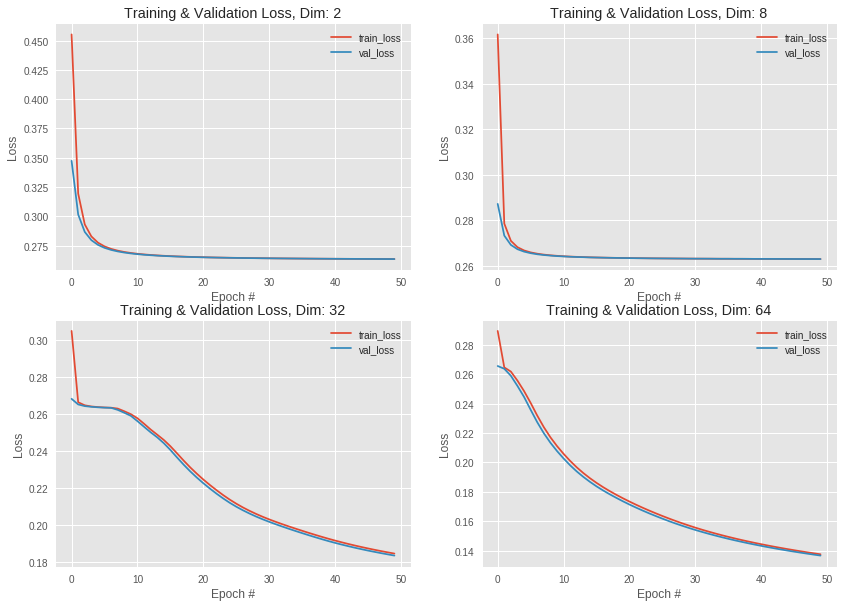

Loss con d = 2: 0.06747093796730042
Loss con d = 8: 0.06747373938560486
Loss con d = 32: 0.038735732436180115
Loss con d = 64: 0.022363703697919846


In [0]:
dims = [2, 8, 32, 64]
plt.style.use("ggplot")
plt.figure(figsize=(14,10))
losses = []

for i,dim in enumerate(dims):
  input_img = Input(shape=(784,))
  encoded = Dense(dim, activation='sigmoid')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img, outputs=encoded)
  encoded_input = Input(shape=(dim,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  autoencoder.fit(x_train,x_train,epochs=50, verbose = 0, batch_size=32,validation_data=(x_val,x_val))

  encoded_test = encoder.predict(x_test)
  decoded_test = decoder.predict(encoded_test)
  lossAE = ((x_test - decoded_test)**2).mean()

  losses.append(lossAE)
  
  plt.subplot(2,2,i+1)
  plt.plot(np.arange(0, 50), autoencoder.history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 50), autoencoder.history.history["val_loss"], label="val_loss")
  plt.title("Training & Validation Loss, Dim: " + str(dim))
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
plt.show()

print("Loss con d = 2: {}".format(losses[0]))
print("Loss con d = 8: {}".format(losses[1]))
print("Loss con d = 32: {}".format(losses[2]))
print("Loss con d = 64: {}".format(losses[3]))

* La función de pérdida de _binary_crossentropy_ es mínima cuando el label que es predecido es el mismo que el real. Lo que se está prediciendo es el valor del píxel, el que se encuentra en el rango $[0,1]$ y su label indica si está siendo usado o es negro, que quiere decir que está más cercano a 1; o que no está siendo usado, siendo blanco la contraparte, o más cercano a 0.

* El porcentaje de compresión es $$(1-\frac{d}{784})*100$$ Siendo $d = [2,8,32,64]$, por lo que, respectivamente, el porcentaje de compresión es $99.74\%$, $98.98\%$, $95.92\%$ y $91.84\%$.

* El error de reconstrucción es obtenido al utilizar _mse_ de las imágenes reales con las imágenes reconstruidas, para cada $d \in {2,8,32,64}$, el error es $0.067$, $0.067$, $0.039$ y $0.022$ respectivamente. Siendo menor al comprimir menos la imagen original.

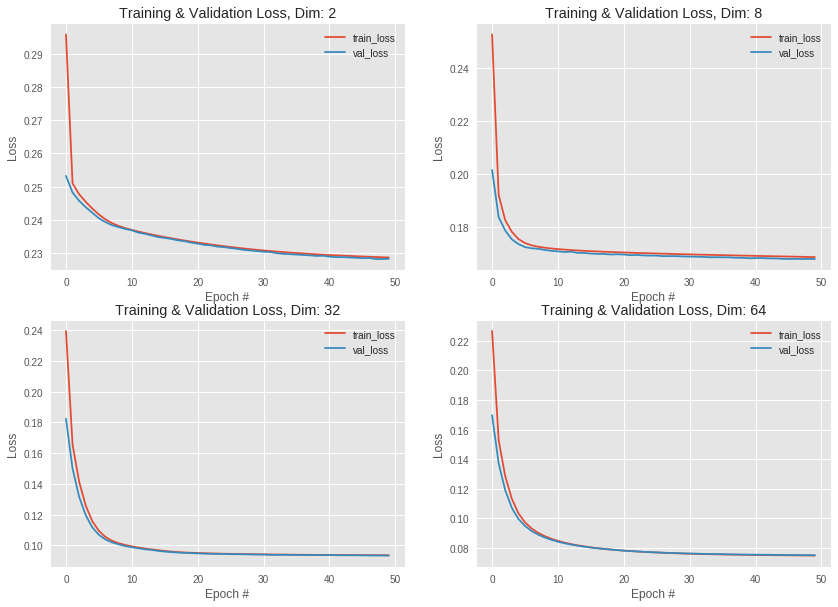

In [0]:
dims = [2, 8, 32, 64]
plt.style.use("ggplot")
plt.figure(figsize=(14,10))

for i,dim in enumerate(dims):
  input_img = Input(shape=(784,))
  encoded = Dense(dim, activation='relu')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img, outputs=encoded)
  encoded_input = Input(shape=(dim,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  autoencoder.fit(x_train,x_train,epochs=50, verbose = 0, batch_size=32,validation_data=(x_val,x_val))

  plt.subplot(2,2,i+1)
  plt.plot(np.arange(0, 50), autoencoder.history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 50), autoencoder.history.history["val_loss"], label="val_loss")
  plt.title("Training & Validation Loss, Dim: " + str(dim))
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
plt.show()

* Una función de activacion de ReLU mejora el resultado del Encoder, ya que al ser todos los valores positivos, la función sigmoid acotaría los valores al rango $[0.5, 1]$, haciendo que los valores sean muy parecidos entre ellos, en cambio, ReLu permite tener una mejor diferenciación de los pixeles al no estar acotado superiormente. 

* Para el Decoder no corresponde utilizar ReLU, ya que la imagen reconstruida debe tener sus pixeles en el rango $[0,1]$, que es justamente las cotas que tiene la función sigmoid, en cambio, relu va desde $[0,\infty]$, por lo que se obtendrían valores fuera del rango establecido previamente.

b) Compare visualmente la reconstrucción que logra hacer el *autoencoder* desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. **Determine si la percepción visual se corresponde con el error de reconstrucción observada**. Comente.

Usando d =  2
Error de reconstrucción: 0.05643541365861893


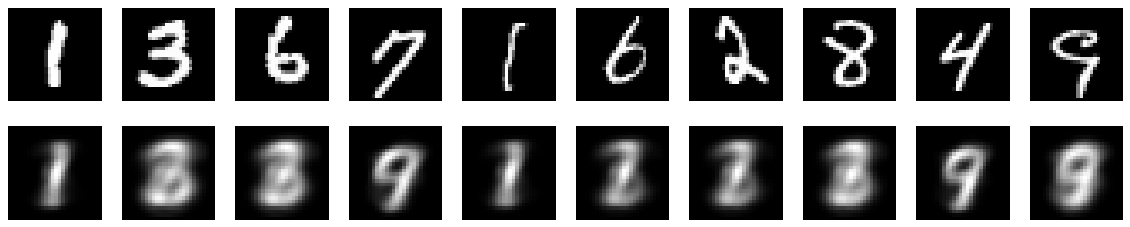

Usando d =  8
Error de reconstrucción: 0.03504372388124466


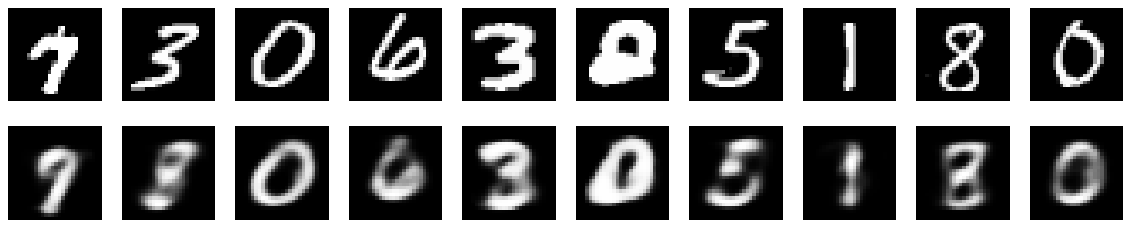

Usando d =  32
Error de reconstrucción: 0.009822591207921505


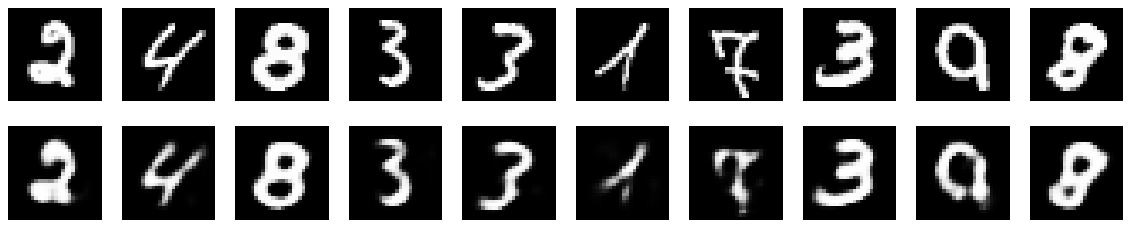

Usando d =  64
Error de reconstrucción: 0.004620012827217579


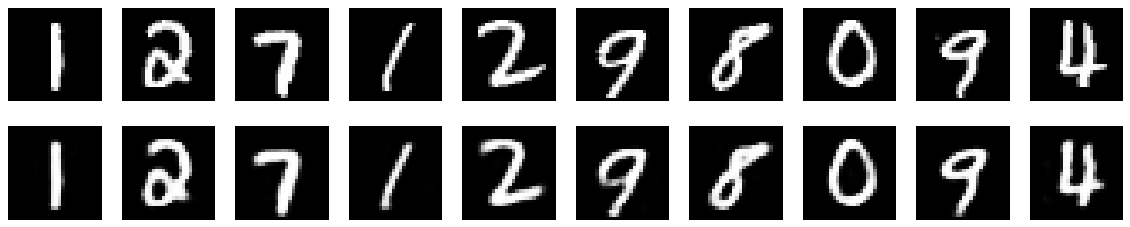

In [0]:
from keras.models import load_model
import matplotlib.pyplot as plt

dims = [2, 8, 32, 64]

for d in dims:
    input_img = Input(shape=(784,))
    encoded = Dense(d, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train,epochs=50, verbose = 0, batch_size=32,validation_data=(x_val,x_val))

    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()
    n = 10
    plt.figure(figsize=(20, 4))
    print("Usando d = ", d)
    print("Error de reconstrucción: {}".format(lossAE))
    for i in range(n):
        j = np.random.randint(0,len(x_test))
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()    

* A mayor error de reconstrucción, el dígito es menos identificable. Utilizando un tamaño de dimensión igual a 64, se puede ver que el error es bastante bajo y, en consecuencia, la imagen reconstruida es casi idéntica a la original.

c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. **Mida el error de pruebas** obtenido construyendo este clasificador sobre la data reducida a través del *autoencoder* comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios **¿La representación generada por el *autoencoder* logra generalizar?**

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import time

dims = [2, 4, 8, 16, 64]

for d in dims:
    input_img = Input(shape=(784,))
    encoded = Dense(d, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train,epochs=50, verbose = 0, batch_size=32,validation_data=(x_val,x_val))
    
    pca = PCA(n_components=d)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    x_test_projected = pca.inverse_transform(pca_test)
    lossPCA = ((x_test - x_test_projected)**2).mean()
    
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()

    print("------ Using d = {} ------".format(d))
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
    print("Loss PCA {}".format(lossPCA))
    
    begin = time.clock()
    clf.predict(pca_test)
    end = time.clock()
    print("Tiempo de predicción PCA: ", end - begin)
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print('Classification Accuracy AE %.2f' % clf.score(encoded_test,y_test))
    print("Loss AE {}".format(lossAE))
    
    begin = time.clock()
    clf.predict(encoded_test)
    end = time.clock()
    print("Tiempo de predicción AE: ", end - begin)

------ Using d = 2 ------
Classification Accuracy PCA 0.44
Loss PCA 0.055664680898189545
Tiempo de predicción PCA:  0.04497500000070431
Classification Accuracy AE 0.40
Loss AE 0.056236978620290756
Tiempo de predicción AE:  0.04963599999973667
------ Using d = 4 ------
Classification Accuracy PCA 0.65
Loss PCA 0.04789749160408974
Tiempo de predicción PCA:  0.13886600000023464
Classification Accuracy AE 0.63
Loss AE 0.047345735132694244
Tiempo de predicción AE:  0.14536299999963376
------ Using d = 8 ------
Classification Accuracy PCA 0.90
Loss PCA 0.03743711858987808
Tiempo de predicción PCA:  0.9031919999997626
Classification Accuracy AE 0.90
Loss AE 0.0345369353890419
Tiempo de predicción AE:  0.7963209999998071
------ Using d = 16 ------
Classification Accuracy PCA 0.96
Loss PCA 0.026855388656258583
Tiempo de predicción PCA:  5.082718000000568
Classification Accuracy AE 0.96
Loss AE 0.021200502291321754
Tiempo de predicción AE:  5.0949030000001585
------ Using d = 64 ------
Classific

* No se observan mayores diferencias entre los resultados utilizando PCA y un Autoencoder. En ambos el accuracy es muy similar, siendo PCA mejor por muy poco.
* Los tiempos que demora cada uno en predecir son variables dependiendo del tamaño de la dimensión, pero son lo suficientemente cercanos para no poder concluir cuál es más rápido.
* En cuanto a los errores de reconstrucción, estos son muy similares entre PCA y Autoencoder. A medida que aumenta el tamaño de la dimensión, el Autoencoder empieza a reducir ligeramente su error de reconstrucción en comparación a PCA.
* Como conclusión, PCA se desempeña de forma similar a un autoencoder simple, y tiene la ventaja de que es más fácil y rápido de usar, al menos en términos de programación.

d) Modifique el *autoencoder* básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. **Demuestre experimentalmente** que este *autoencoder* puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades ($L \in [2,4]$). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

------ Using d = 2 and L = 4 ------


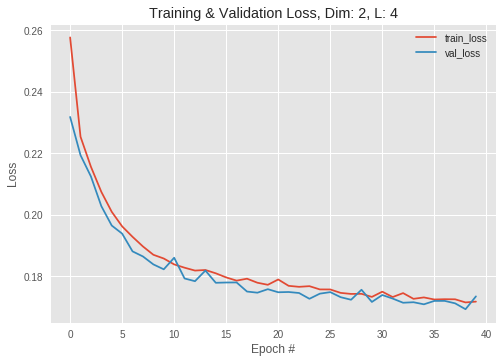

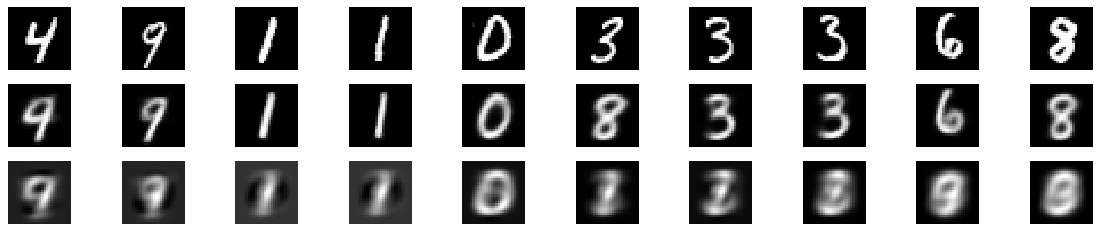

Loss PCA 0.05597850680351257
Classification Accuracy PCA 0.44
Loss AE 0.037718772888183594
Classification Accuracy AE 0.80
------ Using d = 4 and L = 4 ------


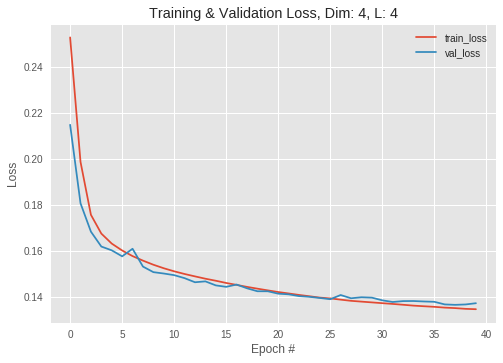

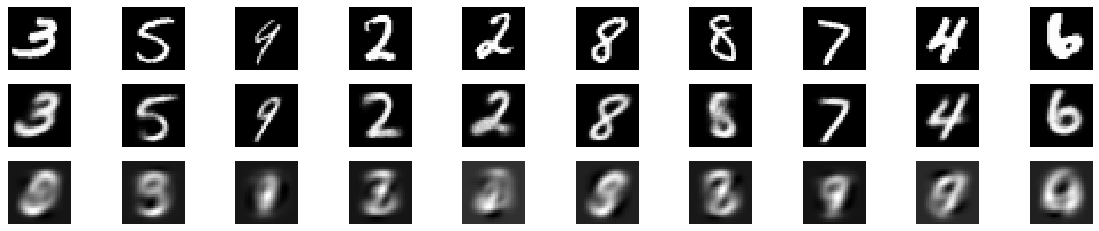

Loss PCA 0.048196207731962204
Classification Accuracy PCA 0.65
Loss AE 0.025564035400748253
Classification Accuracy AE 0.92
------ Using d = 8 and L = 3 ------


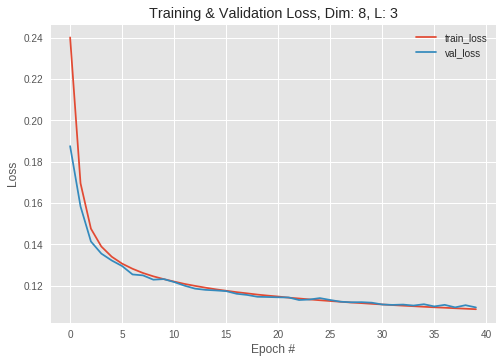

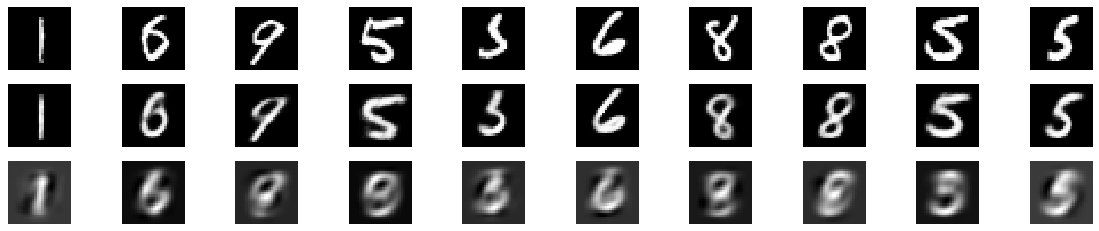

Loss PCA 0.03788596764206886
Classification Accuracy PCA 0.91
Loss AE 0.015863200649619102
Classification Accuracy AE 0.95
------ Using d = 16 and L = 3 ------


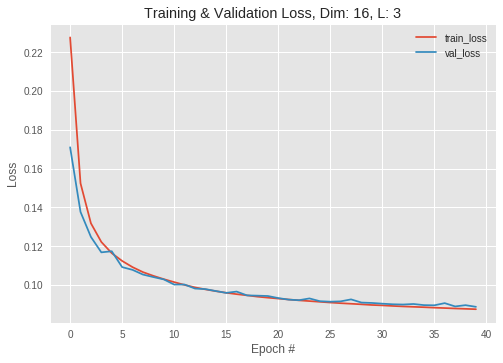

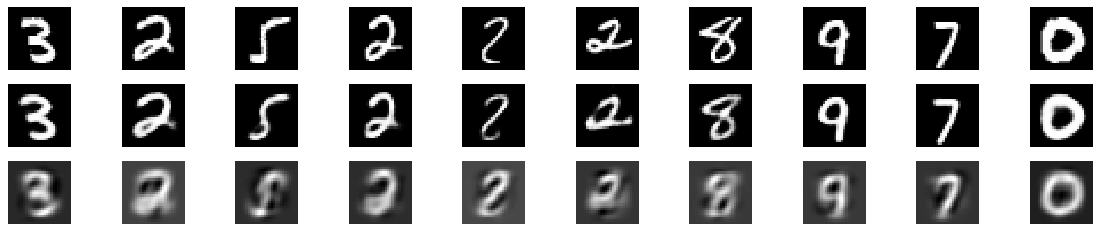

Loss PCA 0.02731345407664776
Classification Accuracy PCA 0.96
Loss AE 0.008855501189827919
Classification Accuracy AE 0.97


In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

dims = [2, 4, 8, 16]
L = [4, 4, 3, 3]

for i, dim in enumerate(dims):
    target_dim = dim
    input_img = Input(shape=(784,))
    if(i < 2):
        encoded1 = Dense(1000, activation='relu')(input_img)
        encoded2 = Dense(500, activation='relu')(encoded1)
        encoded3 = Dense(250, activation='relu')(encoded2)
        encoded4 = Dense(target_dim, activation='relu')(encoded3)
        decoded4 = Dense(250, activation='relu')(encoded4)
        decoded3 = Dense(500, activation='relu')(decoded4)
        decoded2 = Dense(1000, activation='relu')(decoded3)
        decoded1 = Dense(784, activation='sigmoid')(decoded2)
        autoencoder = Model(inputs=input_img, outputs=decoded1)        
        encoder = Model(inputs=input_img, outputs=encoded4)
        encoded_input = Input(shape=(target_dim,))
        layers = autoencoder.layers
        decoder = Model(inputs=encoded_input,
                        outputs=layers[-1](layers[-2](layers[-3](layers[-4](encoded_input)))))
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
        autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))
    else:
        encoded1 = Dense(500, activation='relu')(input_img)
        encoded2 = Dense(250, activation='relu')(encoded1)
        encoded3 = Dense(target_dim, activation='relu')(encoded2)
        decoded3 = Dense(250, activation='relu')(encoded3)
        decoded2 = Dense(500, activation='relu')(decoded3)
        decoded1 = Dense(784, activation='sigmoid')(decoded2)
        autoencoder = Model(inputs=input_img, outputs=decoded1)
        encoder = Model(inputs=input_img, outputs=encoded3)
        encoded_input = Input(shape=(target_dim,))
        layers = autoencoder.layers
        decoder = Model(inputs=encoded_input,
                        outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
        autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))
   
    pca = PCA(n_components=target_dim)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    x_projected = pca.inverse_transform(pca_train)
    loss = ((x_train - x_projected)**2).mean()
    x_projected_test = pca.inverse_transform(pca_test)
    
    print("------ Using d = {} and L = {} ------".format(dim, L[i]))
    plt.style.use("ggplot")
    plt.plot(np.arange(0, 40), autoencoder.history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 40), autoencoder.history.history["val_loss"], label="val_loss")
    plt.title("Training & Validation Loss, Dim: {}, L: {}".format(dim, L[i]))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    n = 10
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        j = np.random.randint(0,len(x_test))
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_projected_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    print("Loss PCA {}".format(loss))
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
    
    print("Loss AE {}".format(lossAE))
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print('Classification Accuracy AE %.2f' % clf.score(encoded_test,y_test))

* El accuracy del autoencoder es superior en cada uno de los experimentos al de PCA, los resultados más notorios son en los que se utilizaron 4 capas para el Deep AE, ya que en estos la dimensión a la que se comprimía era considerablemente pequeña, razón por la cual PCA no tenía buenos resultados. Un ejemplo concreto es usando un tamaño de dimensión 4 y 4 capas, el Deep AE logró una accuracy de $92\%$, mientras que en PCA fue de $65\%$.
* En cuanto al tamaño de la dimensión, como era de esperarse por los experimentos previos, a mayor tamaño, mejor es la reconstrucción de la imagen. Pero al agregar más capas, es posible disminuir el tamaño de la dimensión manteniendo un buen desempeño.

e) Elija algunas de las representaciones aprendidas anteriormente ($d>2$) y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. **Compare cualitativamente el resultado con aquel obtenido usando PCA** con el mismo número de componentes ($d>2$). Finalmente **grafique una representación** generada por un autoencoder directamente ($d=2$), comente.

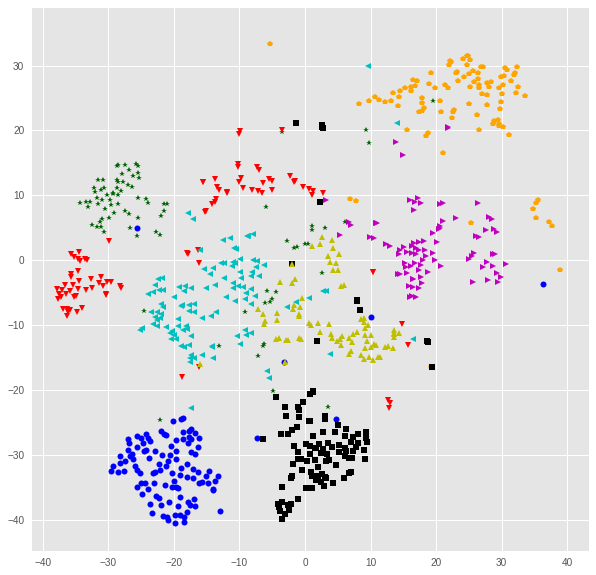

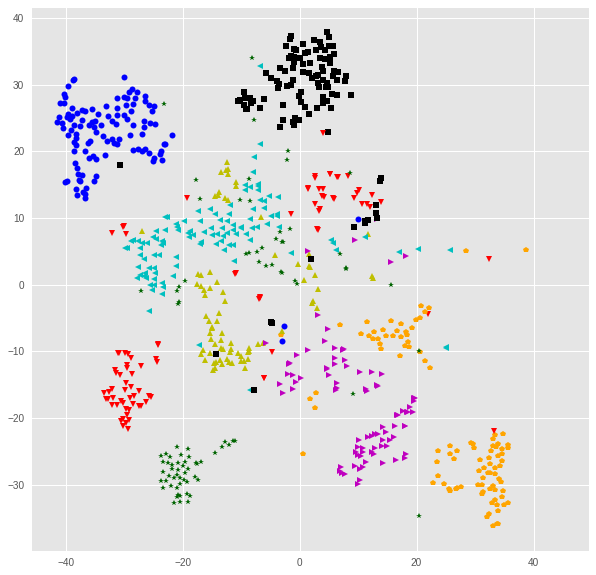

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

target_dim = 16
input_img = Input(shape=(784,))
encoded1 = Dense(500, activation='relu')(input_img)
encoded2 = Dense(250, activation='relu')(encoded1)
encoded3 = Dense(target_dim, activation='relu')(encoded2)
decoded3 = Dense(250, activation='relu')(encoded3)
decoded2 = Dense(500, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded3)
encoded_input = Input(shape=(target_dim,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input,
                outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))

nplot=1000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

pca = PCA(n_components=target_dim)
pca.fit(x_train)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

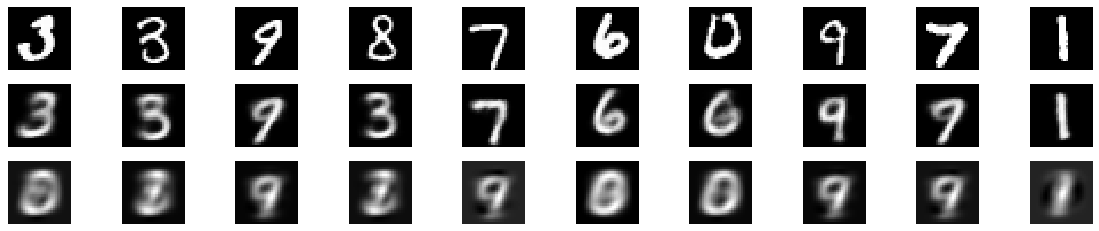

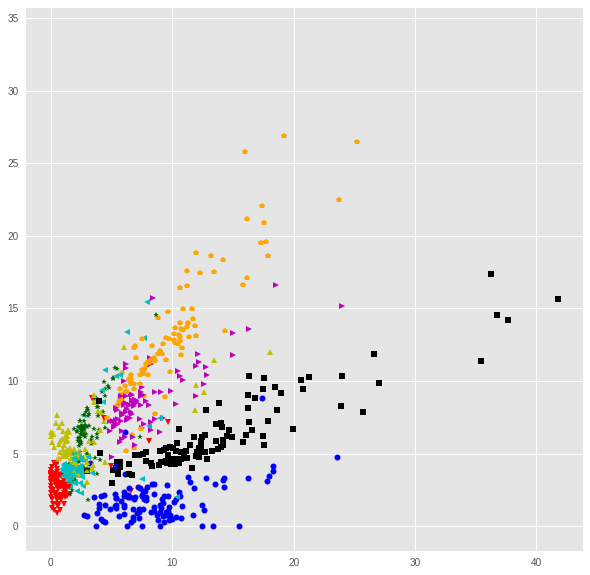

In [0]:
target_dim = 2
input_img = Input(shape=(784,))
encoded1 = Dense(500, activation='relu')(input_img)
encoded2 = Dense(250, activation='relu')(encoded1)
encoded3 = Dense(target_dim, activation='relu')(encoded2)
decoded3 = Dense(250, activation='relu')(encoded3)
decoded2 = Dense(500, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded3)
encoded_input = Input(shape=(target_dim,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input,
                outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))

n = 10
pca = PCA(n_components=target_dim)
pca.fit(x_train)
pca_test = pca.transform(x_test)
x_projected_test = pca.inverse_transform(pca_test)
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_projected_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

encoded_train = encoder.predict(x_train[:nplot]) #Autoencoder with d=2
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

f) Cuando el problema se torna más difícil es necesario complejizar el modelo. Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el *Encoder* y capas con **convoluciones transpuesta** en el *Decoder*, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.

In [0]:
from keras.layers import *

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
input_img = Input(shape=(28, 28, 1))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 16)        0         
__________


### 2.2 Denoising
Como se ha discutido en clases, un *denoising autoencoder* (dAE)[[4]](#refs) es escencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

a) **Genere artificialmente una versión corrupta de las imágenes en MNIST** utilizando el siguiente modelo de ruido (masking noise): si $ x \in {\rm I\!R}^d $ es una de las imágenes originales, la versión ruidosa $\tilde{x}$ se obtiene como $\tilde{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
y_train = y_train[5000:]
y_val = y_train[:5000]
x_val = x_train[:5000]
x_train = x_train[5000:]
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [0]:
from numpy.random import binomial

noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

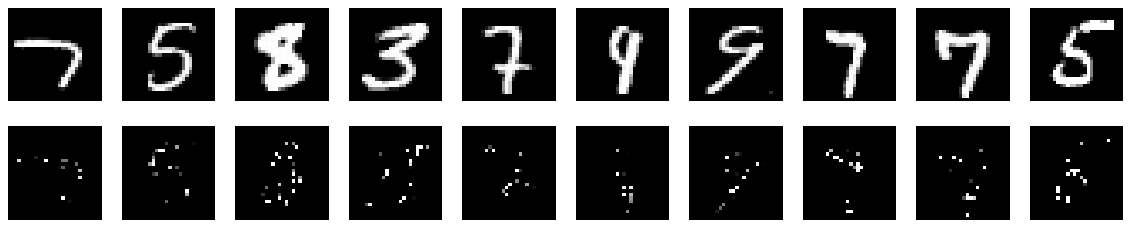

In [0]:
plt.figure(figsize=(20, 4))
n = 10
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(noisy_x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. **Experimente diferentes valores de *p* en el rango (0, 1).**

------ Using noisy level = 0.1 ------


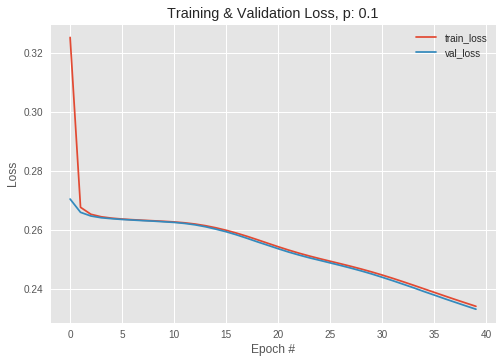

Loss AE 0.05644340068101883


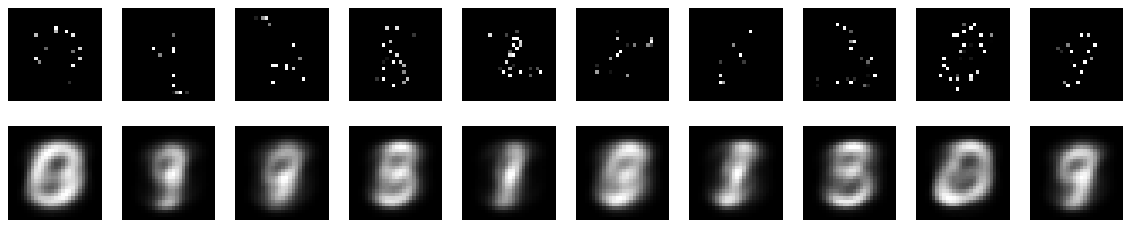

------ Using noisy level = 0.3 ------


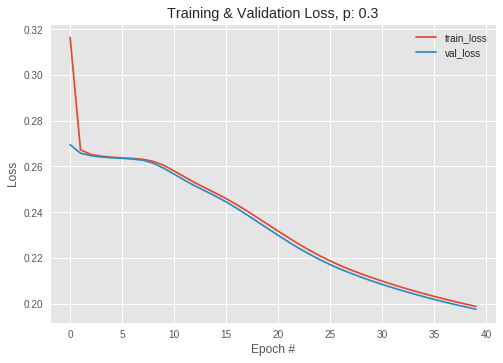

Loss AE 0.0440555103123188


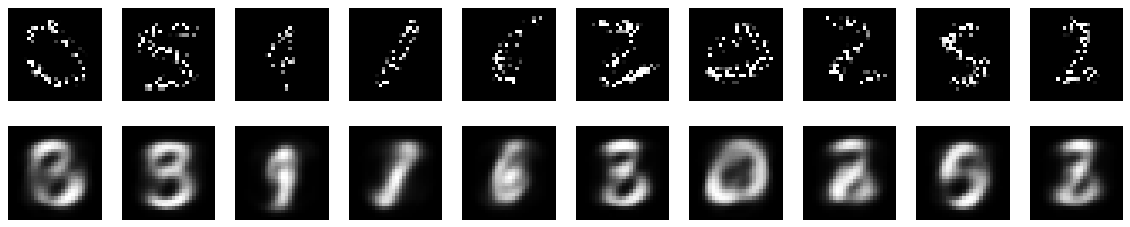

------ Using noisy level = 0.5 ------


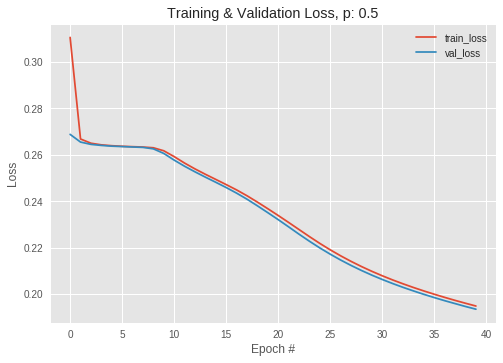

Loss AE 0.04236364737153053


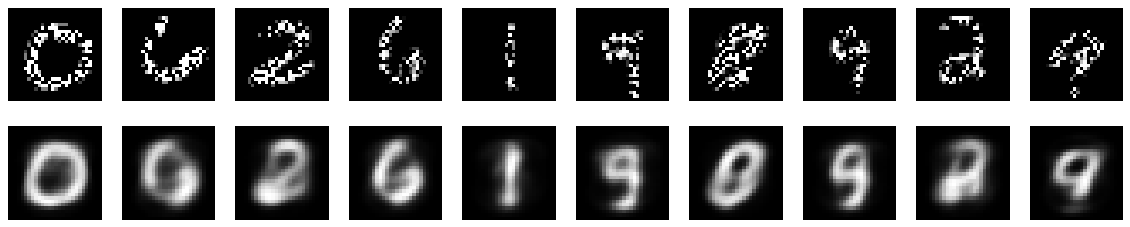

------ Using noisy level = 0.8 ------


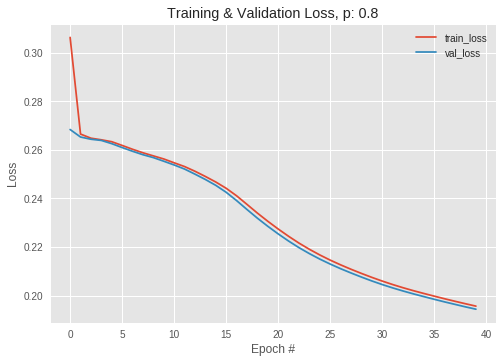

Loss AE 0.042581427842378616


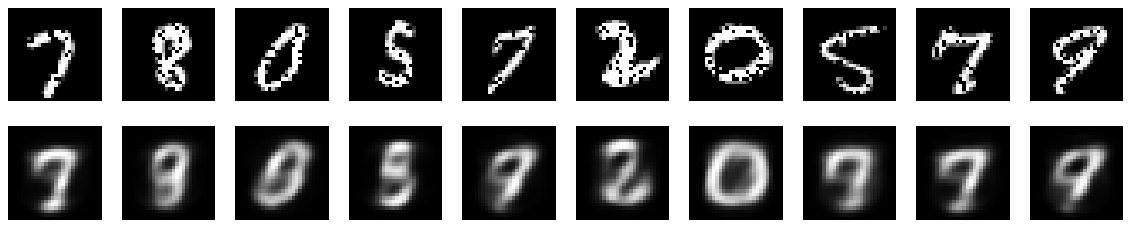

In [0]:
from numpy.random import binomial

ps = [0.1, 0.3, 0.5, 0.8]

for p in ps:
    noise_level = p
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask

    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='sigmoid')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(noisy_x_train, x_train, verbose=0, epochs=40, batch_size=32, validation_data=(noisy_x_val, x_val))
    
    print("------ Using noisy level = {} ------".format(p))
    plt.style.use("ggplot")
    plt.plot(np.arange(0, 40), autoencoder.history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 40), autoencoder.history.history["val_loss"], label="val_loss")
    plt.title("Training & Validation Loss, p: {}".format(p))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()
    
    print("Loss AE {}".format(lossAE))
    
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        j = np.random.randint(0,len(x_test))
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

* Para el ojo humano, según los experimentos, desde un _noisy level_ de 0.3 se distingue vagamente el dígito de la imagen. Sin embargo, el autoencoder es capaz de reconstruir algunos dígitos. Ya con 0.5 el autoencoder se desempeña de mejor manera, con los ocasionales error como por ejemplo confundir los 4 con los 9.

c) Utilice la representación reducida, genera por el *denoising AE*, para **medir el desempeño en clasificación** (vı́a kNN como en la sección anterior). Comente.

In [0]:
noise_level = 0.5
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train, x_train, verbose=0, epochs=40, batch_size=32, validation_data=(noisy_x_val, x_val))

encoded_train = encoder.predict(noisy_x_train)
encoded_test = encoder.predict(noisy_x_test)
decoded_test = decoder.predict(encoded_test)

clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
print('Classification Accuracy denoising AE %.2f' % clf.score(encoded_test,y_test))

Classification Accuracy denoising AE 0.79


* Al utilizar un valor de ruido de 0.5, la accuracy del autoencoder no es mala, pero no logra a desempeñarse de la misma forma que utilizando imágenes sin ruido. Se necesita una mejor implementación para alcanzar un mayor accuracy y reconstruir de mejor forma las imágenes.

d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

In [0]:
import cv2

def corruptImages(imgs):
    imgs = np.asarray(list(map(lambda x: cv2.GaussianBlur(x, ksize=(9,9), sigmaX=1), imgs)))
    imgs = np.asarray(list(map(lambda x: cv2.GaussianBlur(x, ksize=(3,3), sigmaX=0), imgs)))
    imgs = np.asarray(list(map(lambda x: cv2.morphologyEx(x, cv2.MORPH_GRADIENT, kernel=(5,5)), imgs)))
    return imgs

* Para corromper las imágenes, se utilizó un filtro Gaussiano que suaviza la imagen haciendo que se pierdan detalles. Esto se realizó 2 veces con distintos tamaños del filto. Luego, se realiza una operación morfológica que solo deja los bordes de los dígitos, dejando las imágenes mayormente negras.

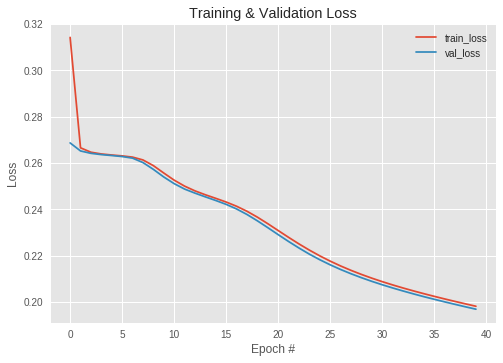

Loss AE 0.044510506093502045


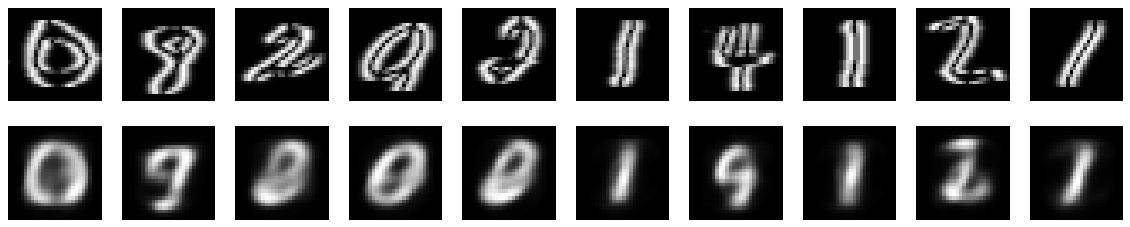

In [0]:
corrupted_x_train = corruptImages(x_train).reshape((len(x_train),784))
corrupted_x_val = corruptImages(x_val).reshape((len(x_val),784))
corrupted_x_test = corruptImages(x_test).reshape((len(x_test),784))

input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(corrupted_x_train, x_train, verbose=0, epochs=40, batch_size=32, validation_data=(corrupted_x_val, x_val))

plt.style.use("ggplot")
plt.plot(np.arange(0, 40), autoencoder.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), autoencoder.history.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

encoded_test = encoder.predict(corrupted_x_test)
decoded_test = decoder.predict(encoded_test)
lossAE = ((x_test - decoded_test)**2).mean()

print("Loss AE {}".format(lossAE))

encoded_test = encoder.predict(corrupted_x_test)
decoded_test = decoder.predict(encoded_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(corrupted_x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

* La reconstrucción de la imagen falla en la mayoría de las clases, siendo el dígito 1 el mejor reconstruido en base al experimento anterior.
* Para el error de reconstrucción se constrasta la imagen original, sin corromper, junto con la reconstrucción generada por el encoder. El error no es bastante alto para este contexto, lo que corresponde a las imágenes de ejemplo mostradas.

### 2.3 *Similarity reconstruct*

En esta sección se explorará una forma diferente de implementar un *autoencoder* que es utilizar la arquitectura del *autoencoder* pero no para reconstruir el mismo dato, sino que para reconstruir un dato similar. En este caso la similaridad estará dada por las clases de los datos.

a) Genere pares de objetos $(objeto,similar)$ con 10 datos similares al dato "objeto", para ésto utilice la función que se provee a continuación sobre los primeros (1000 a 2000) datos de entrenamiento. **Visualice los nuevos datos generados y la relación que se produce entre los pares de objetos**.

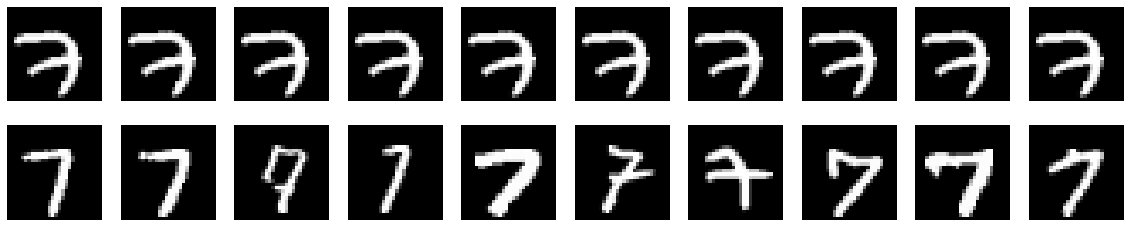

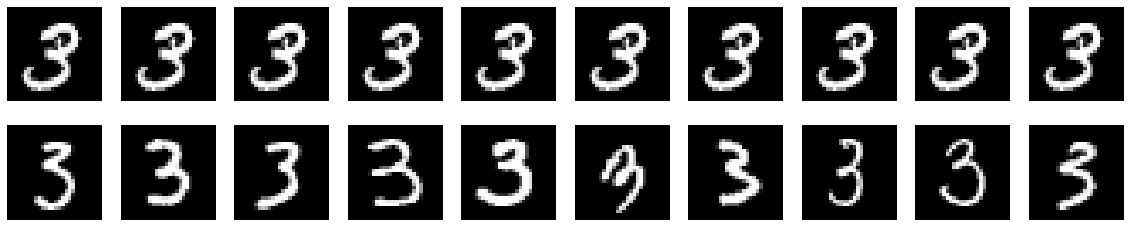

In [0]:
def similarity_data(X,Y,sim=10):
    index_classes = [ np.where(Y==number)[0] for number in range(10)]
    new_X = np.zeros((1,X.shape[1]))
    simi_X = np.zeros((1,X.shape[1]))
    for x,y in zip(X,Y):
        similarities = index_classes[y]
        sample_sim = np.random.choice(similarities,sim)
        new_X = np.concatenate((new_X, np.tile(x,(sim,1))),axis=0)
        simi_X = np.concatenate((simi_X, X[sample_sim]),axis=0)
    return new_X[1:],simi_X[1:]
data, data_sim = similarity_data(x_train[:2000],y_train[:2000])

n = 10
j = -1
for k in range(2):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j += 1
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(data[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(data_sim[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

* Las primeras 10 imágenes de _data_ corresponden a exactamente la misma imagen, pero las 10 imágenes de _data_sim_ muestra imágenes distintas y de la misma clase.

b) Escoga algunas de las arquitecturas ya experimentadas hasta este punto de la actividad y entrénela para enfrentarla a éste problema **¿La función de pérdida se mantiene?**

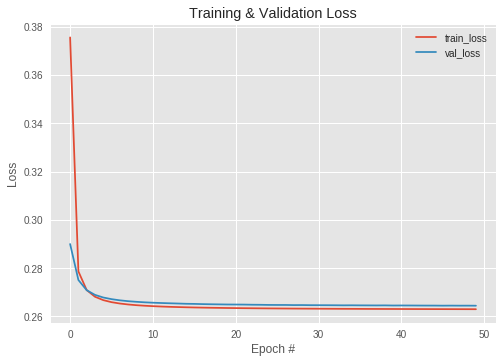

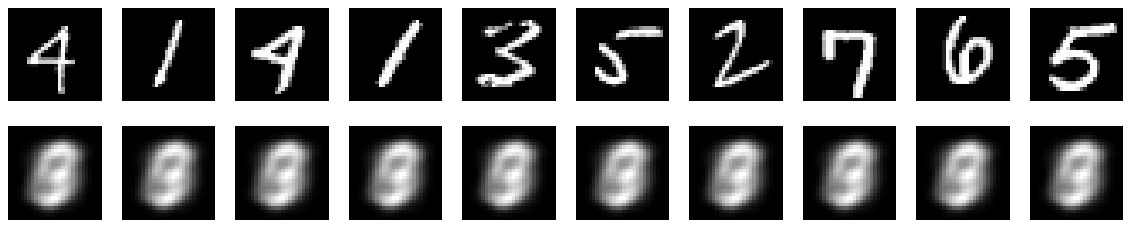

In [0]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(data,data_sim,verbose=0,epochs=50,batch_size=32,validation_split=0.2)

plt.style.use("ggplot")
plt.plot(np.arange(0, 50), autoencoder.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), autoencoder.history.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

* El autoencoder entrega malos resultados visuales, por lo que la función de pérdida debería ser distinta a la utilizada típicamente. Se pueden ver en las reconstrucciones que todas son iguales y que no se distingue dígito alguno en ellas.

c) **Visualice lo que genera el *autoencoder* dado una imagen de entrada**. Además **visualice, con la herramienta TSNE, los *embedding*/representación reducida** que se producen en el *encoder*.

In [0]:
from sklearn.manifold import TSNE

target_dim = 16
input_img = Input(shape=(784,))
encoded1 = Dense(500, activation='relu')(input_img)
encoded2 = Dense(250, activation='relu')(encoded1)
encoded3 = Dense(target_dim, activation='relu')(encoded2)
decoded3 = Dense(250, activation='relu')(encoded3)
decoded2 = Dense(500, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded3)
encoded_input = Input(shape=(target_dim,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input,
                outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))

nplot=1000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca = PCA(n_components=target_dim)
pca.fit(x_train)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]

target_dim = 2
input_img = Input(shape=(784,))
encoded1 = Dense(500, activation='relu')(input_img)
encoded2 = Dense(250, activation='relu')(encoded1)
encoded3 = Dense(target_dim, activation='relu')(encoded2)
decoded3 = Dense(250, activation='relu')(encoded3)
decoded2 = Dense(500, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded3)
encoded_input = Input(shape=(target_dim,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input,
                outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))

n = 10
pca = PCA(n_components=target_dim)
pca.fit(x_train)
pca_test = pca.transform(x_test)
x_projected_test = pca.inverse_transform(pca_test)
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_projected_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

encoded_train = encoder.predict(x_train[:nplot]) #Autoencoder with d=2
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

In [0]:
autoencoder.predict(data)
embeddings = encoder.predict(data) #project this with TSNE

### 2.4 Pre-*training*

En esta sección utilizaremos un AE para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice SGD básico con tasa de aprendizaje fija $\eta = 0.01$, momentum $m=0.9$ y no más de 50 *epochs*. Para empezar, utilice una arquitectura $784 \times 1000 \times 1000 \times 10$ y **funciones de activación sigmoidales**. **Determine error de clasificación alcanzado por el modelo en el conjunto de test.**

In [0]:
from keras.utils import to_categorical
Y_train = to_categorical(y_train, 10)
Y_val = to_categorical(y_val, 10)
Y_test = to_categorical(y_test, 10)
from keras.models import Sequential
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train ,verbose = 0, epochs=50, batch_size=32,shuffle=True, validation_data=(x_val, Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_118 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_119 (Dense)            (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


In [0]:
loss, acc = model.evaluate(x_test, Y_test, verbose=0)
print("El error de clasificación es de {}".format(loss))
print("El accuracy fue de {}".format(acc))

El error de clasificación es de 0.07920345958927646
El accuracy fue de 0.976


b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*fine-tunning*). **Compare los resultados de clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *fine-tunning*.** Comente.

In [0]:
n_hidden_layer1 = 1000
n_hidden_layer2 = 1000
_optimizer = SGD(lr=0.01, momentum=0.9)
activation_layer1 = "relu"
activation_layer2 = "relu"
decoder_activation_1 = "sigmoid"
decoder_activation_2 = "sigmoid"
loss_ = "binary_crossentropy"
batch_size_ = 32
epochs_ = 40

In [0]:
from keras.datasets import mnist
## Load and preprocess MNIST as usual

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=epochs_, verbose = 0, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1, verbose = 0, epochs=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train, epochs=20, verbose = 0, batch_size=32, shuffle=True, validation_data=(x_val, Y_val))

In [0]:
loss, acc = model.evaluate(x_test, Y_test, verbose=0)
print("El error de clasificación es de {}".format(loss))
print("El accuracy fue de {}".format(acc))

El error de clasificación es de 14.535298237609863
El accuracy fue de 0.0982


c) Repita usando funciones de **activación *tanh*. Comente**

In [0]:
n_hidden_layer1 = 1000
n_hidden_layer2 = 1000
_optimizer = SGD(lr=0.01, momentum=0.9)
activation_layer1 = "tanh"
activation_layer2 = "tanh"
decoder_activation_1 = "tanh"
decoder_activation_2 = "tanh"
loss_ = "binary_crossentropy"
batch_size_ = 32
epochs_ = 40

In [0]:
from keras.datasets import mnist
## Load and preprocess MNIST as usual

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=epochs_, verbose = 0, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,epochs=epochs_, verbose = 0, batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train, epochs=20, batch_size=32, verbose = 0, shuffle=True, validation_data=(x_val, Y_val))

In [0]:
loss, acc = model.evaluate(x_test, Y_test, verbose=0)
print("El error de clasificación es de {}".format(loss))
print("El accuracy fue de {}".format(acc))

El error de clasificación es de 0.11010551452157451
El accuracy fue de 0.9745


## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.